In [1]:
from langchain_community.tools import DuckDuckGoSearchRun
duckduckgo_search_run = DuckDuckGoSearchRun()
duckduckgo_search_run.invoke("What is the weather in yangon")

D:\anaconda3\Lib\asyncio\events.py:88: UserWarning: lxml is not installed. Using backend='api'.
  self._context.run(self._callback, *self._args)


"In Yangon, at the moment, there is widespread cloud cover, bringing a cooler and darker setting. The temperature is a temperate 29°C, the felt air temperature, which adjusts the air temperature based on humidity, registers as assessed at a torrid 37°C.The current temperature is nearly at the maximum expected 31°C for today. Yangon Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Yangon area. Today's Weather - Yangon, MMR. March 12, 2025 12:18 AM YANGON INTL MYAN . 81° Feels Like 86° Hi--Lo 80°F. Warm and Humid. Live Radar. Weather Details. Windchill 82ºF Daily Rain--Dewpoint 73ºF Monthly Rain-- Humidity 74% Avg. Wind W 5mph; Pressure--Wind Gust--Sunrise 6:16 AM Moon Waxing ... Yangon - Weather forecast from Theweather.com. Weather conditions with updates on temperature, humidity, wind speed, snow, pressure, etc. for Yangon, Myanmar Providing a local hourly Yangon weather forecast of rain, s

In [2]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
import os

weather_search = OpenWeatherMapAPIWrapper()
weather_search.run("Yangon, Myanmar")

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
model = ChatGroq(model_name= "deepseek-r1-distill-llama-70b")

In [5]:

from langchain_core.tools import tool
import warnings
@tool
def duckduckgo_search(query: str) -> str:
    """Search Latest Weather News in Myanmar in DuckDuckGo and return including Location"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return DuckDuckGoSearchRun(query=query, source="news").invoke(query)

@tool
def weather_search(city: str, country: str) -> str:
    """Retrieve the weather information for a specific city and country"""
    weather_search = OpenWeatherMapAPIWrapper()
    return weather_search.run(f"{city}, {country}")

tools = [duckduckgo_search, weather_search]
tools

[StructuredTool(name='duckduckgo_search', description='Search Latest Weather News in Myanmar in DuckDuckGo and return including Location', args_schema=<class 'langchain_core.utils.pydantic.duckduckgo_search'>, func=<function duckduckgo_search at 0x0000029BD2DEB7E0>),
 StructuredTool(name='weather_search', description='Retrieve the weather information for a specific city and country', args_schema=<class 'langchain_core.utils.pydantic.weather_search'>, func=<function weather_search at 0x0000029BD5C12AC0>)]

In [6]:
model_with_tools = model.bind_tools(tools)
model_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000029BD52D28D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000029BD5C0B020>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'duckduckgo_search', 'description': 'Search Latest Weather News in Myanmar in DuckDuckGo and return including Location', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'weather_search', 'description': 'Retrieve the weather information for a specific city and country', 'parameters': {'properties': {'city': {'type': 'string'}, 'country': {'type': 'string'}}, 'required': ['city', 'country'], 'type': 'object'}}}]}, config={}, config_factories=[])

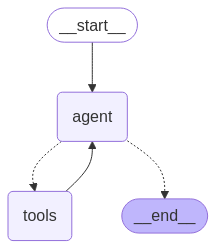

In [7]:
from langgraph.prebuilt import create_react_agent

system_prompt = """Act as a helpful assistant.
Use the tools at your disposal to perform tasks as needed.
    -duckduckgo_search: use this tool for CURRENT NEWS in Myanmar including LOCATION and MAGNITUDE.
Use the tools if you do not know answer.
"""
agent = create_react_agent(model=model, tools=tools, state_modifier= system_prompt)
agent

In [8]:
from datetime import datetime

inputs = {"messages": [("user", f"Earthquake news in Myanmar: {datetime.now().strftime("%d:%m:%y")}, including Latitude and Longitude")]}
#weather_input = {"messages": [('user', "Next 2 days weather in Yangon Myanmar")]}

result = agent.invoke(inputs, stream_mode="values")

In [9]:
result

{'messages': [HumanMessage(content='Earthquake news in Myanmar: 15:04:25, including Latitude and Longitude', additional_kwargs={}, response_metadata={}, id='3ce2349c-b669-48ef-a759-fab42a40d658'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p9fm', 'function': {'arguments': '{"query": "earthquake in Myanmar including latitude and longitude"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 331, 'prompt_tokens': 245, 'total_tokens': 576, 'completion_time': 1.203636364, 'prompt_time': 0.020551895, 'queue_time': 0.21174801199999999, 'total_time': 1.224188259}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-70d4c9e5-5158-45e6-944d-5822bbc540e4-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'earthquake in Myanmar including latitude and longitude'}, 'id': 'call_p9fm', 'type': 'tool_call'}], us

In [11]:
final = result['messages'][-1].content
final

"Here is the latest news about earthquakes in Myanmar, including their locations and magnitudes:\n\n1. **Earthquake in Mae Hong Son's Pai District**  \n   - **Magnitude**: 1.8  \n   - **Location**: Tambon Mae Na Toeng, Pai District  \n   - **Epicentre**: 1 kilometre deep  \n   - **Time**: 9:42 AM  \n\n2. **Earthquake in Myanmar (Sagaing Region)**  \n   - **Magnitude**: 5.9  \n   - **Depth**: 10 kilometres  \n   - **Epicentre**: Latitude 21.065° North, Longitude 96...  \n   - **Time**: 9:24 AM (Thailand time)  \n\n3. **Earthquake near Sagaing**  \n   - **Magnitude**: Unspecified  \n   - **Depth**: 10 kilometres  \n   - **Epicentre**: Latitude 21.93° N, Longitude 96.07° E  \n   - **Time**: 11:50 AM (local time)  \n\n4. **Strong Earthquake in Mandalay Region**  \n   - **Magnitude**: 7.7 Richter Scale  \n   - **Epicentre**: 20 kilometres northeast of Mandalay  \n   - **Location**: Latitude 22.09°N, Longitude 96.23°E  \n   - **Depth**: 10 kilometres  \n\n5. **Earthquake near Mingin**  \n   

In [2]:
final = "Here is the latest news about earthquakes in Myanmar, including their locations and magnitudes:\n\n1. **Earthquake in Mae Hong Son's Pai District**  \n   - **Magnitude**: 1.8  \n   - **Location**: Tambon Mae Na Toeng, Pai District  \n   - **Epicentre**: 1 kilometre deep  \n   - **Time**: 9:42 AM  \n\n2. **Earthquake in Myanmar (Sagaing Region)**  \n   - **Magnitude**: 5.9  \n   - **Depth**: 10 kilometres  \n   - **Epicentre**: Latitude 21.065° North, Longitude 96...  \n   - **Time**: 9:24 AM (Thailand time)  \n\n3. **Earthquake near Sagaing**  \n   - **Magnitude**: Unspecified  \n   - **Depth**: 10 kilometres  \n   - **Epicentre**: Latitude 21.93° N, Longitude 96.07° E  \n   - **Time**: 11:50 AM (local time)  \n\n4. **Strong Earthquake in Mandalay Region**  \n   - **Magnitude**: 7.7 Richter Scale  \n   - **Epicentre**: 20 kilometres northeast of Mandalay  \n   - **Location**: Latitude 22.09°N, Longitude 96.23°E  \n   - **Depth**: 10 kilometres  \n\n5. **Earthquake near Mingin**  \n   - **Magnitude**: 3.5 Richter Scale  \n   - **Epicentre**: 27 miles northeast of Mingin  \n   - **Location**: Latitude 22.96°N, Longitude 94.74°E  \n   - **Depth**: 28 kilometres  \n   - **Time**: 11:06:47 M.S.T on April 14, 2025  \n\nLet me know if you'd like more details!"


In [3]:
import re 

pattern = r"Latitude\s([\d.]+°\s?[Nn]?),\s*Longitude\s([\d.]+°\s?[Ee]?)"

matches = re.findall(pattern, final)
matches

[('21.93° N', '96.07° E'), ('22.09°N', '96.23°E'), ('22.96°N', '94.74°E')]

In [4]:
for lat, lon in matches:
    print(f"Latitude: {lat}, Longitude: {lon}")

Latitude: 21.93° N, Longitude: 96.07° E
Latitude: 22.09°N, Longitude: 96.23°E
Latitude: 22.96°N, Longitude: 94.74°E


In [5]:
import folium
import webbrowser

coordinates = []
for lat, lon in matches:
    try:
        clean_lat = float(re.sub(r"[^\d.]", "", lat))
        clean_lon = float(re.sub(r"[^\d.]", "", lon))
        coordinates.append((clean_lat, clean_lon))
    except ValueError:
        print(f"Skipping invalid coordinates: {lat}, {lon}")

In [6]:
coordinates

[(21.93, 96.07), (22.09, 96.23), (22.96, 94.74)]

In [ ]:
for coords in coordinates:
    folium.Marker(location=[coords[0], coords[1]]).add_to(folium_map)


AttributeError: module 'folium.map' has no attribute 'add_child'